Importing the required libraries


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
plt.rcParams.update({'font.size': 18})

Writing the required functions

In [30]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid

Importing the fits files

Filename: ../FITS_file/DR21_Her250_Repr.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU    1094   (110, 93)   float64   
None


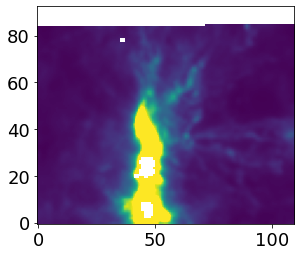

In [53]:
########## importing and testing the file
FITS1 = '../FITS_file/CygX_E_OTFMAP.fits'
FITS2 = '../FITS_file/DR21_NH2_Repr.fits'
FITS3 = '../FITS_file/DR21_Tdust_Repr.fits'
FITS4 = '../FITS_file/DR21_IRAC4_Repr.fits'
FITS5 = '../FITS_file/DR21_Her250_Repr.fits'
hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
print(hdul5.info())

MapStokesI = hdul[0]
MapStokesIError = hdul[1]

MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]

MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()

######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data
Selector = (MapPolSNR.data < 3)

BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
# BlankedMapHer250.data[Selector] = np.nan

Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
# BlankedMapHer250.data[Selector] = np.nan


Selector = MapStokesI.data/MapStokesIError.data < 25
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
# BlankedMapHer250.data[Selector] = np.nan

BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
# BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)



############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

plt.figure()
plt.imshow(MapHer250.data,origin='lower',vmin = 1,vmax = 45)
plt.show()


In [32]:

set_delta = 0.5   # in arcminute
S_map = BlankedMapPolAngle.copy()
sigma_S_map = BlankedMapPolAngleError.copy()

for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):

        ##### seperation filter
        seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation_selector = (seperation.data<0.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data>1.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data >0)

        ##### making the dispersion map
        tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
        tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
        AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
        S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
        S_map.data[i,j] = S

        ##### making the dispersion error map
        sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
        sigma_S_map.data[i,j] = sigma_S



/tmp/ipykernel_8123/2043383840.py:20: RuntimeWarning: Mean of empty slice
  S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
/tmp/ipykernel_8123/2043383840.py:24: RuntimeWarning: Mean of empty slice
  sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5


Debiasing the dispersion map

/tmp/ipykernel_8123/1420896820.py:2: RuntimeWarning: invalid value encountered in sqrt
  S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)


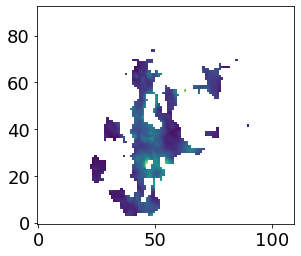

In [33]:
S_map_deb = S_map.copy()
S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)
plt.imshow(S_map_deb.data,origin='lower')
plt.show()

Plotting the relations between p, nh2 and s 

Fitting the curves to individual relations between p vs I, s and NH2

Fitting the double parameter function log p  = C + alpha_s log s + alpha_I log I and log p  = C + alpha_s log s + alpha_NH2 log NH2

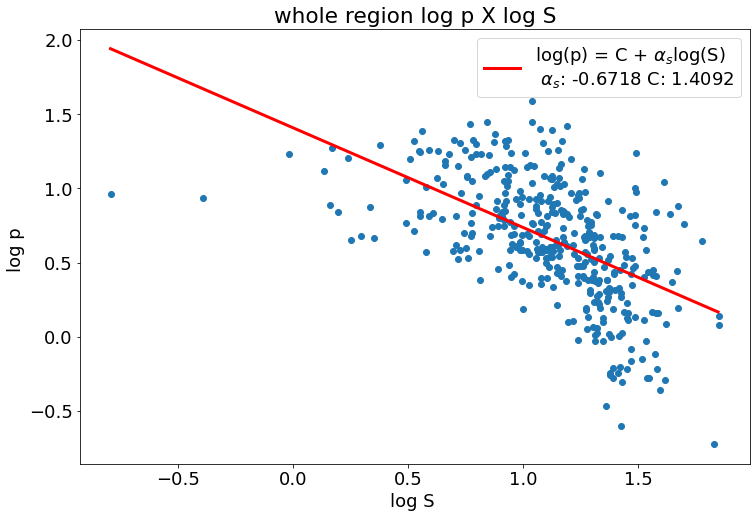

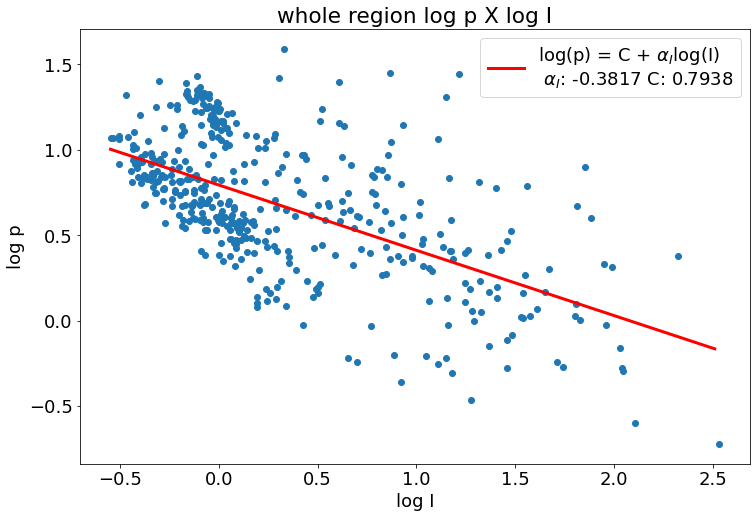

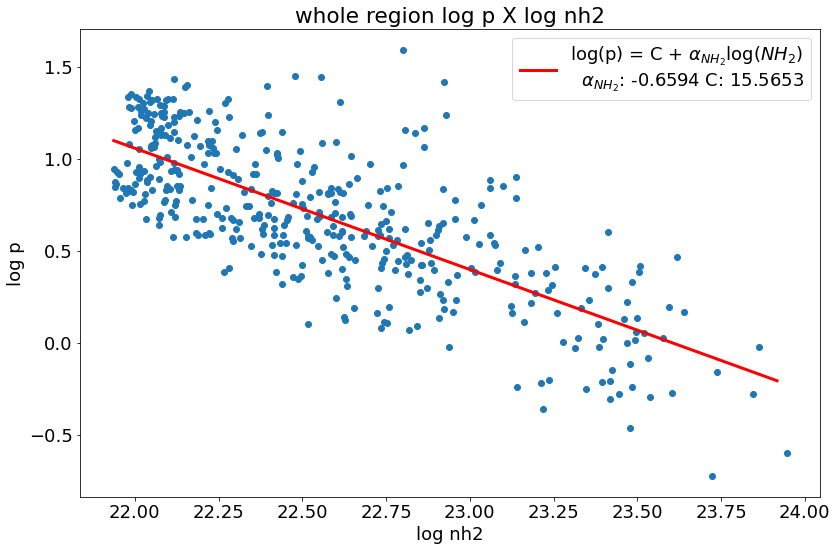

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


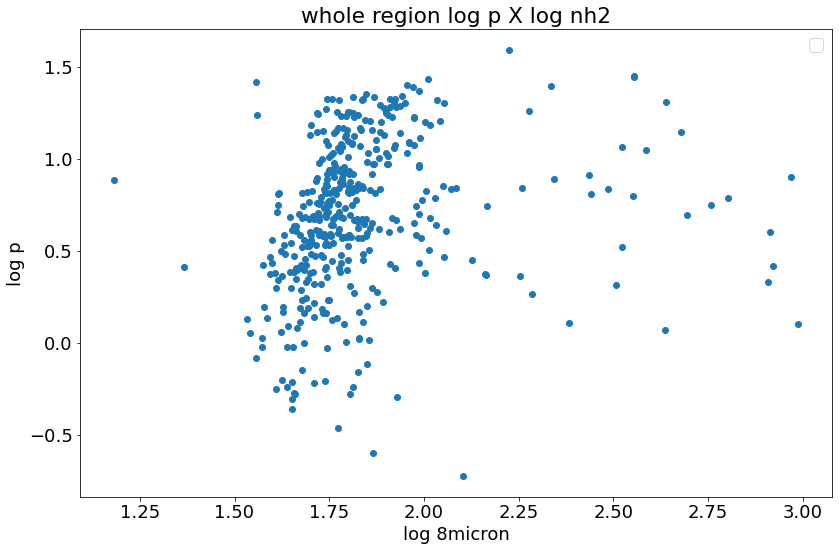

C : 1.253786282683197
s index : -0.44250118023641766
I index : -0.2837762253236341
C : 13.732243862090034
s index : -0.21475318074031824
nh2 index : -0.5677338600092279


In [34]:
def lin_fit(x, a, b):
    return a + b*x

s_array = S_map_deb.data.flatten()
p_array = BlankedMapPol.data.flatten()
I_array = BlankedMapStokesI.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
micron8_array = BlankedMap8Mircon.data.flatten()

s_array_ind = s_array.copy()
s_array_ind = s_array_ind[::4]
p_array_ind = p_array.copy()
p_array_ind = p_array_ind[::4]
I_array_ind = I_array.copy()
I_array_ind = I_array_ind[::4]
nh2_array_ind = nh2_array.copy()
nh2_array_ind = nh2_array_ind[::4]
micron8_array_ind = micron8_array.copy()
micron8_array_ind = micron8_array_ind[::4]

log_s = np.log10(s_array_ind)
log_p = np.log10(p_array_ind)
log_I = np.log10(I_array_ind)
log_nh2 = np.log10(nh2_array_ind)
log_8micron = np.log10(micron8_array_ind)


p_min = np.nanmin(log_p)
p_max = np.log(50)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.arange(p_min, p_max, 0.06)
s_bins = np.arange(s_min, s_max, 0.06)
I_bins = np.arange(I_min, I_max, 0.06)
nh2_bins = np.arange(nh2_min,nh2_max, 0.06)
micron8_bins = np.arange(micron8_min,micron8_max,0.06)


df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2,'log_8micron':log_8micron})
df_log = df_log.dropna()

PS_param, PS_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc = lin_fit(s_bins,PS_param[0],PS_param[1])

PI_param, PI_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc = lin_fit(I_bins,PI_param[0],PI_param[1])

Pnh2_param, Pnh2_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc = lin_fit(nh2_bins,Pnh2_param[0],Pnh2_param[1])

fig = plt.subplots(figsize =(12, 8))
ax1 = plt.subplot(111)
ax1.scatter(log_s,log_p)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_param[1],C = PS_param[0],linebreak='\n')
ax1.plot(s_bins,PS_FitFunc,'r',linewidth=3,label = label_temp)
ax1.set_title("whole region log p X log S")
ax1.set_ylabel('log p ')
ax1.set_xlabel('log S ')

fig = plt.subplots(figsize =(12, 8))
ax2 = plt.subplot(111)
ax2.scatter(log_I,log_p)
label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_param[1],C = PI_param[0],linebreak='\n')
ax2.plot(I_bins,PI_FitFunc,'r',linewidth=3,label = label_temp)
ax2.set_title("whole region log p X log I")
ax2.set_ylabel('log p')
ax2.set_xlabel('log I')

fig = plt.subplots(figsize =(12, 8))
ax3 = plt.subplot(111)
ax3.scatter(log_nh2,log_p)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
ax3.plot(nh2_bins,Pnh2_FitFunc,'r',linewidth=3,label = label_temp)
ax3.set_title("whole region log p X log nh2")
ax3.set_ylabel('log p')
ax3.set_xlabel('log nh2')
plt.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

fig = plt.subplots(figsize =(12, 8))
ax3 = plt.subplot(111)
ax3.scatter(log_8micron,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# ax3.plot(micron8_bins,Pnh2_FitFunc,'r',linewidth=3,label = label_temp)
ax3.set_title("whole region log p X log nh2")
ax3.set_ylabel('log p')
ax3.set_xlabel('log 8micron')
plt.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

p0 = -0.2278,-0.3994,2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('nh2 index :',PSI_param_lower[2])

Bootstrap error estimation of the whole region.

In [35]:
s_whole_array = S_map_deb.data.flatten()
p_whole_array = BlankedMapPol.data.flatten()
nh2_whole_array = BlankedMapColumnDensity.data.flatten()


# log_s = np.log(s_whole_array)
# log_p = np.log(p_whole_array)
# log_nh2 = np.log(nh2_whole_array)

log_s = np.arange(0,20,0.1) 
log_s = log_s + np.random.normal(1, 1, log_s.shape)
log_nh2 = np.arange(20,40,0.1) 
log_nh2 = log_nh2 + np.random.normal(1, 1, log_s.shape)
log_p = 10 + (-1)*log_s + log_nh2*(-0.5)


df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return param
    return np.sqrt(np.diag(param_cov))


bootarr = np.array(df_log)


bootresult = bootstrap(bootarr,10,bootfunc=curve_fitting)
print(bootresult)
# print('error in alpha_s',np.std(bootresult[:,1]))
# print('error in alpha_nh2',np.std(bootresult[:,2]))

param, param_cov = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']),df_log['logp'])
# param_cov = curve_fitting(bootarr)


[[10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]]


In [36]:
DEC_array = DEC_grid.flatten()
RA_array = RA_grid.flatten()
StokesI_array = BlankedMapStokesI.data.flatten()
S_array = S_map_deb.data.flatten()
P_array = BlankedMapPol.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
temperature_array = BlankedMapTemperature.data.flatten()
PolAngleNonRotated_array = BlankedMapPolAngleNonRotated.data.flatten()
micron8_array = BlankedMap8Mircon.data.flatten()

df = pd.DataFrame({'RA': RA_array, 'DEC': DEC_array,'P':P_array ,'I': StokesI_array,'S':S_array,'ColumnDen':nh2_array,'Temperature':temperature_array,'8micron':micron8_array})
df.to_csv('data_dr21_with8micron.csv',sep=chr(44))

Dividing the whole region into sub-regions

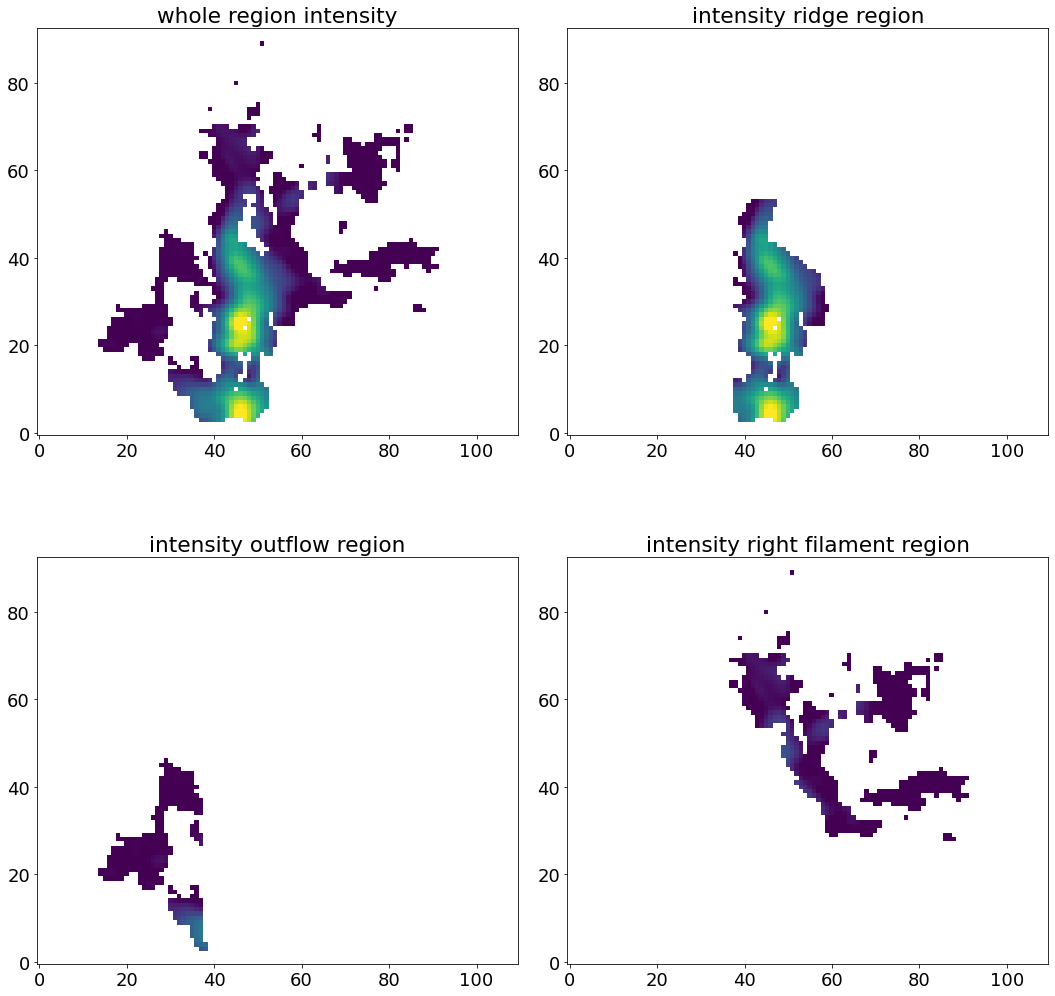

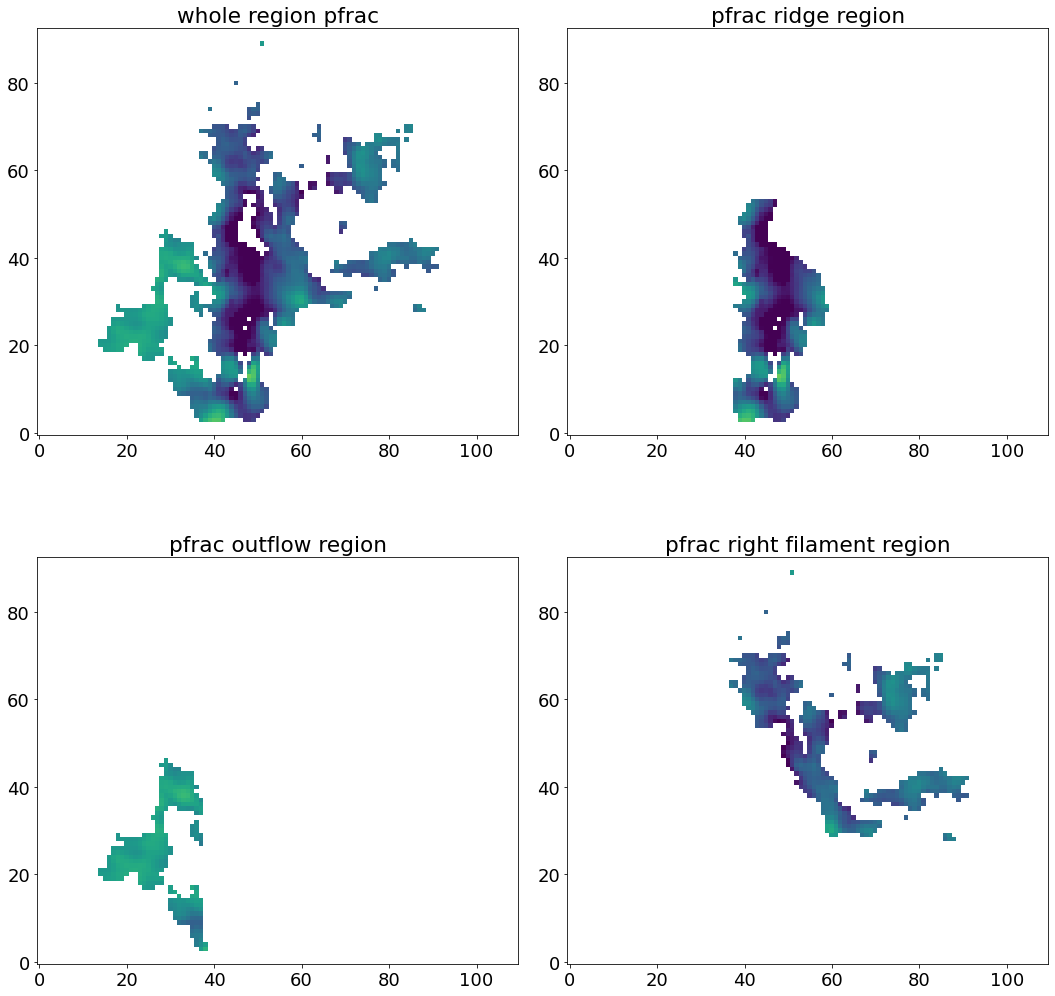

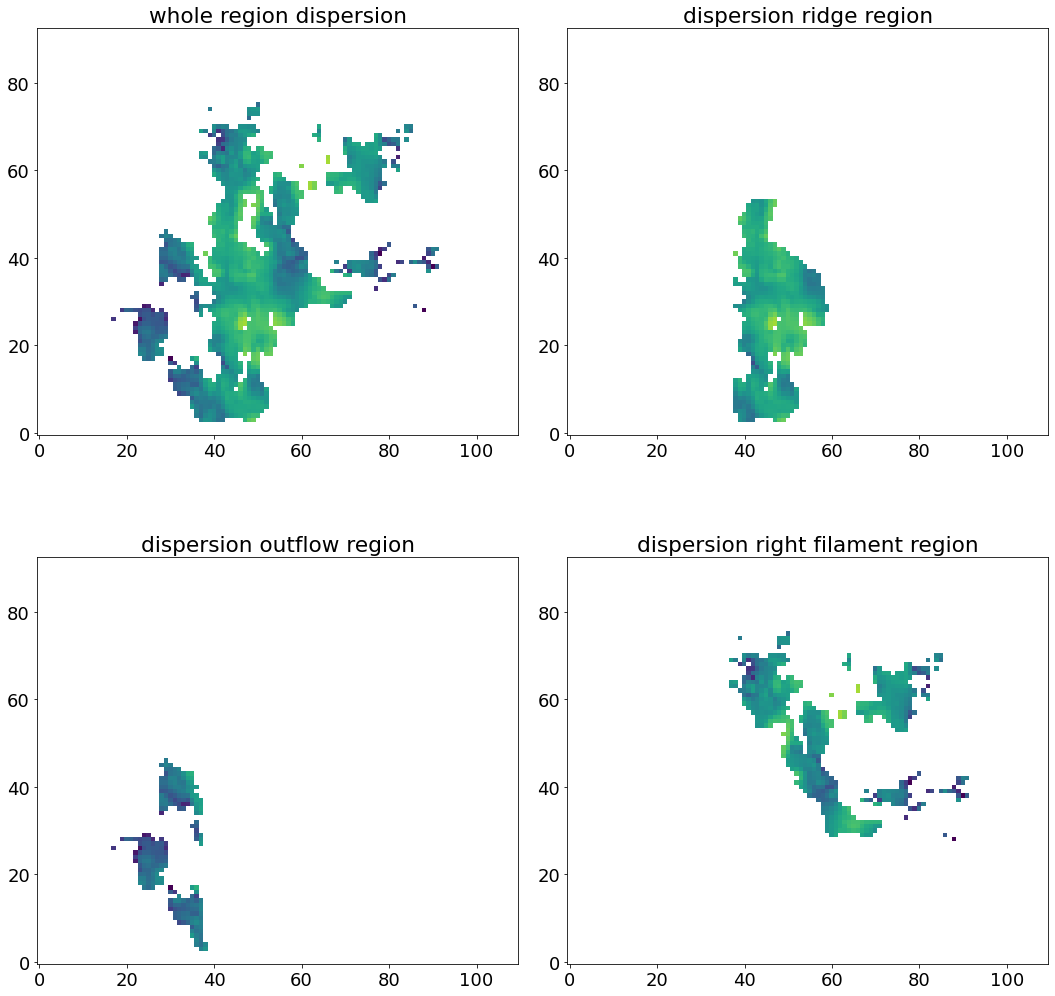

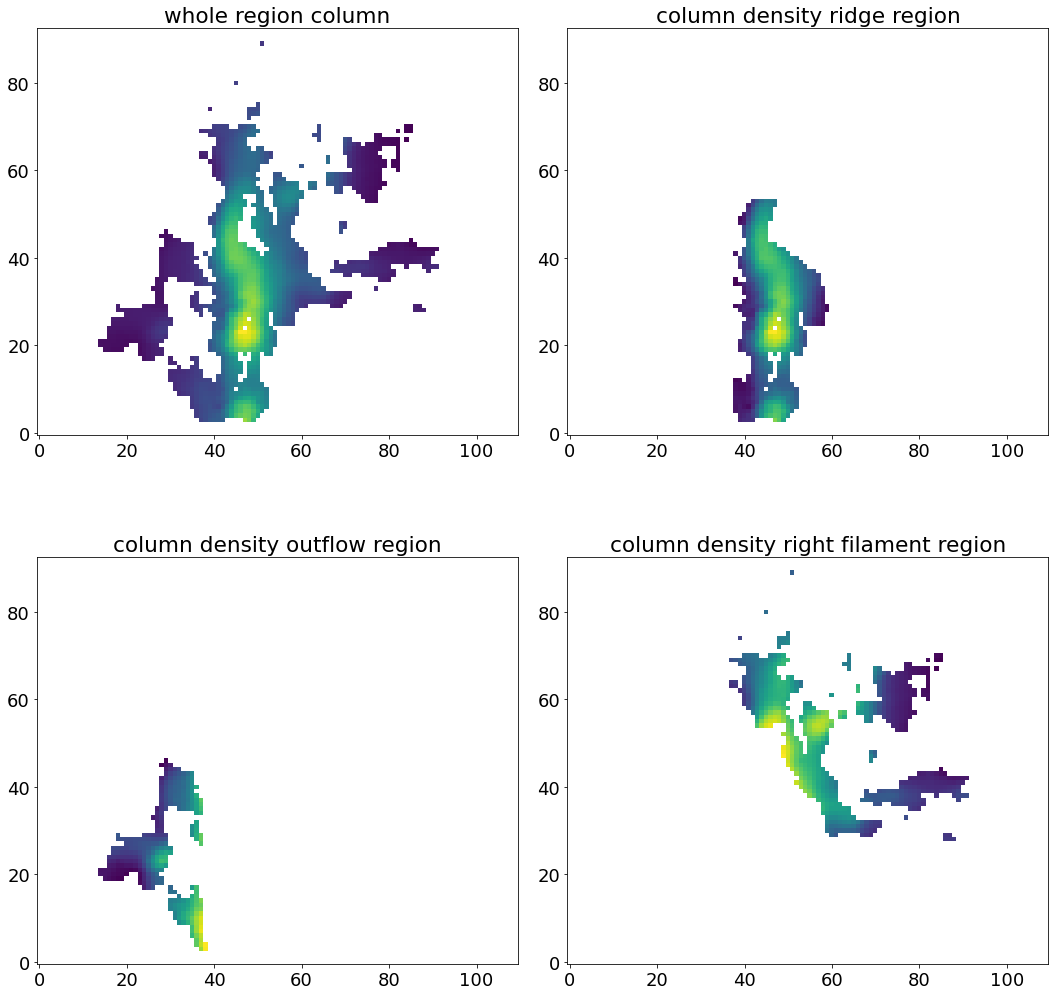

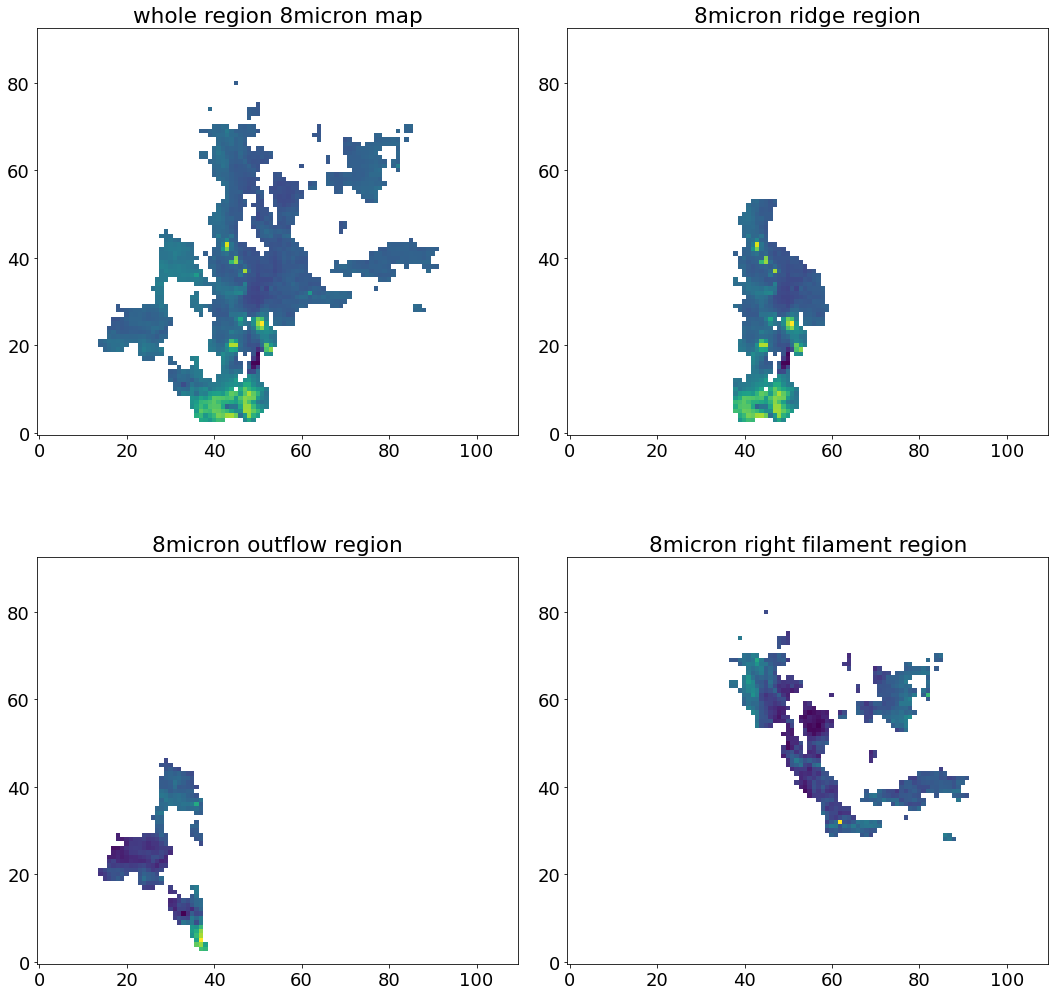

In [37]:
def line_1(x, y):
    top_x = 309.9258719
    top_y = 42.4556451
    bottom_x = 309.7452960
    bottom_y =   42.4556451
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_2(x, y):
    top_x = 309.7838598
    top_y = 42.4569364
    bottom_x = 309.7792727
    bottom_y =  42.3127837
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_3(x, y):
    top_x = 309.7468561
    top_y = 42.4529922
    bottom_x = 309.7507272
    bottom_y =  42.4299500
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_4(x, y):
    top_x = 309.7507272
    top_y = 42.4305231
    bottom_x = 309.7108001
    bottom_y =  42.4094674
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_5(x, y):
    top_x = 309.7108001
    top_y = 42.4094674
    bottom_x = 309.699191
    bottom_y =  42.3710874
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

I_ridge_plus_fill_right= BlankedMapStokesI.copy()
p_ridge_plus_fill_right = BlankedMapPol.copy()
s_ridge_plus_fill_right = S_map_deb.copy()
nh2_ridge_plus_fill_right = BlankedMapColumnDensity.copy()
micron8_ridge_plus_fill_right = BlankedMap8Mircon.copy()

I_outflow = BlankedMapStokesI.copy()
p_outflow = BlankedMapPol.copy()
s_outflow = S_map_deb.copy()
nh2_outflow = BlankedMapColumnDensity.copy()
micron8_outflow = BlankedMap8Mircon.copy()


selector = (line_1(RA_grid,DEC_grid)<0)*(line_2(RA_grid,DEC_grid)<0)
I_ridge_plus_fill_right.data[selector] = np.nan
p_ridge_plus_fill_right.data[selector] = np.nan
s_ridge_plus_fill_right.data[selector] = np.nan
nh2_ridge_plus_fill_right.data[selector] = np.nan
micron8_ridge_plus_fill_right.data[selector] = np.nan

selector = ~selector
I_outflow.data[selector] = np.nan
p_outflow.data[selector] = np.nan
s_outflow.data[selector] = np.nan
nh2_outflow.data[selector] = np.nan
micron8_outflow.data[selector] = np.nan


I_fil_right = I_ridge_plus_fill_right.copy()
p_fil_right = p_ridge_plus_fill_right.copy()
s_fil_right = s_ridge_plus_fill_right.copy()
nh2_fil_right = nh2_ridge_plus_fill_right.copy()
micron8_fil_right = micron8_ridge_plus_fill_right.copy()

I_ridge = I_ridge_plus_fill_right.copy()
p_ridge = p_ridge_plus_fill_right.copy()
s_ridge = s_ridge_plus_fill_right.copy()
nh2_ridge = nh2_ridge_plus_fill_right.copy()
micron8_ridge = micron8_ridge_plus_fill_right.copy()


selector = (line_1(RA_grid,DEC_grid)>0)+ (line_3(RA_grid,DEC_grid)<0)*(line_4(RA_grid,DEC_grid)>0) + (line_5(RA_grid,DEC_grid)>0)
  
I_ridge.data[selector] = np.nan
p_ridge.data[selector] = np.nan
s_ridge.data[selector] = np.nan
nh2_ridge.data[selector] = np.nan
micron8_ridge.data[selector] = np.nan

selector = ~selector
I_fil_right.data[selector] = np.nan
p_fil_right.data[selector] = np.nan
s_fil_right.data[selector] = np.nan
nh2_fil_right.data[selector] = np.nan
micron8_fil_right.data[selector] = np.nan

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(BlankedMapStokesI.data),origin='lower',vmin=0,vmax = 5)
ax1.set_title('whole region intensity')
ax2 = plt.subplot(222)
ax2.imshow(np.log(I_ridge.data),origin = 'lower',vmin=0,vmax = 5)
ax2.set_title('intensity ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(I_outflow.data),origin = 'lower',vmin=0,vmax = 5)
ax3.set_title('intensity outflow region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(I_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
ax4.set_title('intensity right filament region')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(BlankedMapPol.data),origin='lower',vmin=0,vmax = 5)
ax1.set_title('whole region pfrac')
ax2 = plt.subplot(222)
ax2.imshow(np.log(p_ridge.data),origin = 'lower',vmin=0,vmax = 5)
ax2.set_title('pfrac ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(p_outflow.data),origin = 'lower',vmin=0,vmax = 5)
ax3.set_title('pfrac outflow region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(p_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
ax4.set_title('pfrac right filament region')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(S_map_deb.data),origin='lower',vmin=0,vmax = 5)
ax1.set_title('whole region dispersion')
ax2 = plt.subplot(222)
ax2.imshow(np.log(s_ridge.data),origin = 'lower',vmin=0,vmax = 5)
ax2.set_title('dispersion ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(s_outflow.data),origin = 'lower',vmin=0,vmax = 5)
ax3.set_title('dispersion outflow region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(s_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
ax4.set_title('dispersion right filament region')
plt.tight_layout()
plt.show()


fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(BlankedMapColumnDensity.data),origin='lower')
ax1.set_title('whole region column')
ax2 = plt.subplot(222)
ax2.imshow(np.log(nh2_ridge.data),origin = 'lower')
ax2.set_title('column density ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(nh2_outflow.data),origin = 'lower')
ax3.set_title('column density outflow region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(nh2_fil_right.data),origin = 'lower')
ax4.set_title('column density right filament region')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(BlankedMap8Mircon.data),origin='lower')
ax1.set_title('whole region 8micron map')
ax2 = plt.subplot(222)
ax2.imshow(np.log(micron8_ridge.data),origin = 'lower')
ax2.set_title('8micron ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(micron8_outflow.data),origin = 'lower')
ax3.set_title('8micron outflow region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(micron8_fil_right.data),origin = 'lower')
ax4.set_title('8micron right filament region')
plt.tight_layout()
plt.show()


In [63]:
# I_outflow.writeto('outflow.fits')
# I_fil_right.writeto('fil_right.fits')
# I_ridge.writeto('ridge.fits')
# matplotlib.image.imsave('../ridge.png', I_ridge.data,origin='lower',vmin=0,vmax=50)
# matplotlib.image.imsave('../right_fil.png', I_fil_right.data,origin='lower',vmin=0,vmax=50)
# matplotlib.image.imsave('../outflow.png', I_outflow.data,origin='lower',vmin=0,vmax=50)
# matplotlib.image.imsave('../Her250.png', MapHer250.data,cmap='Greys',origin='lower',vmin=0,vmax=50)
matplotlib.image.imsave('../Pfrac.png', BlankedMapPol.data,origin='lower',vmin=0,vmax=50)

print(I_ridge.data.shape)




(93, 110)


Analysis of the outflow region

<bound method NDFrame.head of           logp      logs      logI     lognh2  log_8micron
92    1.397013  1.126870  0.609203  22.394354     2.334491
119   0.914118  0.924536  0.668388  22.292156     2.435123
174   0.888841  0.917834  0.800085  22.308765     2.342985
229   0.744113  0.891751  0.790672  22.332512     2.166363
256   0.700614  0.743073  0.625290  22.245906     1.986975
...        ...       ...       ...        ...          ...
1163  1.111407  0.856661 -0.177287  22.104514     1.988685
1190  1.084930  0.834133 -0.193980  22.060510     1.961291
1191  1.104362  1.332522 -0.428531  22.129919     1.873977
1218  0.983503  0.987819 -0.346802  22.074555     1.848448
1245  1.053159  0.917409 -0.358624  22.013408     1.872393

[62 rows x 5 columns]>


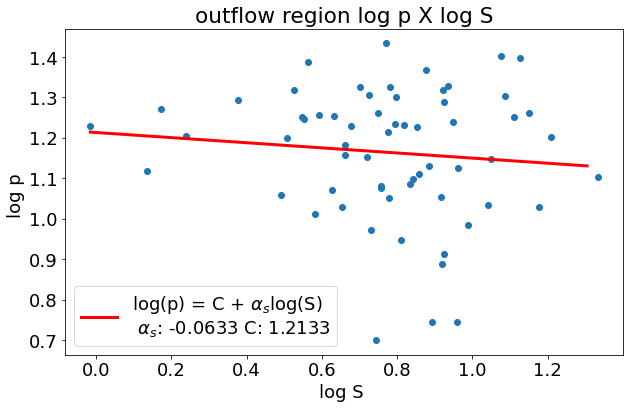

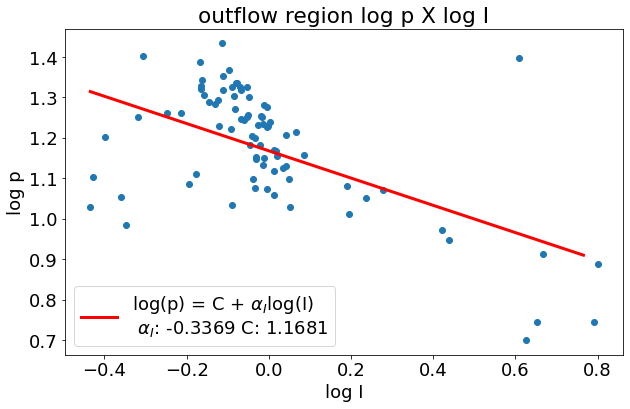

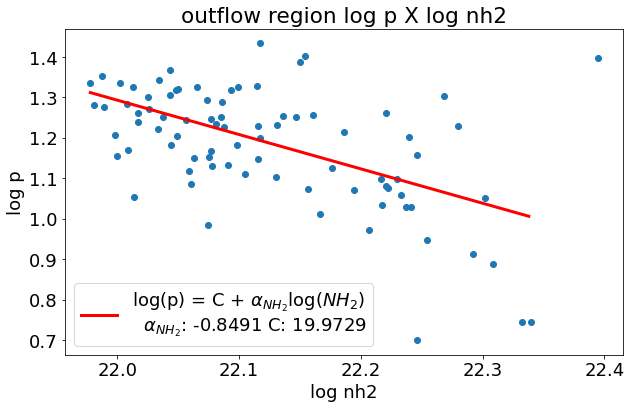

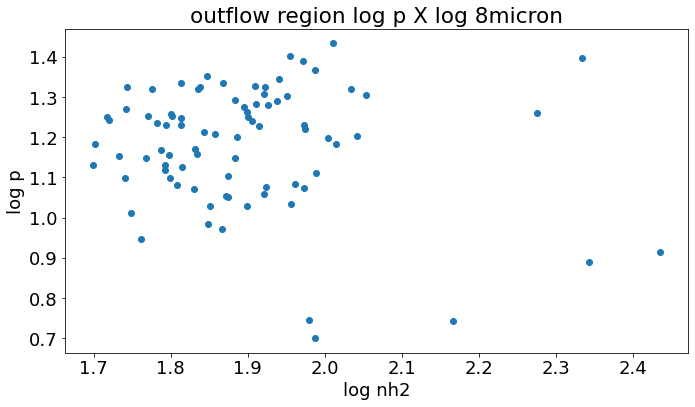

C : 1.2354222603251175
s index : -0.08654593625234493
I index : -0.3418413487607159
C : 20.587261199246818
s index : 0.0341279982829762
nh2 index : -0.8780077589264722


In [38]:
def lin_fit(x, a, b):
    return a + b*x

s_outflow_array = s_outflow.data.flatten()
p_outflow_array = p_outflow.data.flatten()
I_outflow_array = I_outflow.data.flatten()
nh2_outflow_array = nh2_outflow.data.flatten()
micron8_outflow_array = micron8_outflow.data.flatten()

s_outflow_array_ind = s_outflow_array.copy()
s_outflow_array_ind = s_outflow_array_ind[::4]
p_outflow_array_ind = p_outflow_array.copy()
p_outflow_array_ind = p_outflow_array_ind[::4]
I_outflow_array_ind = I_outflow_array.copy()
I_outflow_array_ind = I_outflow_array_ind[::4]
nh2_outflow_array_ind = nh2_outflow_array.copy()
nh2_outflow_array_ind = nh2_outflow_array_ind[::4]
micron8_outflow_array_ind = micron8_outflow_array.copy()
micron8_outflow_array_ind = micron8_outflow_array_ind[::4]

log_s = np.log10(s_outflow_array_ind)
log_p = np.log10(p_outflow_array_ind)
log_I = np.log10(I_outflow_array_ind)
log_nh2 = np.log10(nh2_outflow_array_ind)
log_8micron = np.log10(micron8_outflow_array_ind)

p_min = np.nanmin(log_p)
p_max = np.log(50)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.arange(p_min, p_max, 0.06)
s_bins = np.arange(s_min, s_max, 0.06)
I_bins = np.arange(I_min, I_max, 0.06)
nh2_bins = np.arange(nh2_min,nh2_max, 0.06)
micron8_bins = np.arange(micron8_min,micron8_max,0.06)


df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2,'log_8micron':log_8micron})
df_log = df_log.dropna()

print(df_log.head)
PS_outflow_param, PS_outflow_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_outflow = lin_fit(s_bins,PS_outflow_param[0],PS_outflow_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_outflow_param, PI_outflow_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_outflow = lin_fit(I_bins,PI_outflow_param[0],PI_outflow_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_outflow_param, Pnh2_outflow_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_outflow = lin_fit(nh2_bins,Pnh2_outflow_param[0],Pnh2_outflow_param[1])


# fig = plt.subplots(figsize =(15, 30))
# ax1 = plt.subplot(312)
# ax1.scatter(log_s,log_p)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_outflow_param[1],C = PS_outflow_param[0],linebreak='\n')
# ax1.plot(s_bins,PS_FitFunc_outflow,'r',linewidth=3,label = label_temp)
# ax2 = plt.subplot(311)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_outflow_param[1],C = PI_outflow_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_outflow,'r',linewidth=3,label = label_temp)
# ax3 = plt.subplot(313)
# ax3.scatter(log_nh2,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_outflow_param[1],C = Pnh2_outflow_param[0],linebreak='\n')
# ax3.plot(nh2_bins,Pnh2_FitFunc_outflow,'r',linewidth=3,label = label_temp)

# ax1.set_title("outflow log p X log S")
# ax1.set_ylabel('log p ')
# ax1.set_xlabel('log S ')
# ax2.set_title("outflow log p X log I")
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')
# ax3.set_title("outflow log p X log nh2")
# ax3.set_ylabel('log p')
# ax3.set_xlabel('log nh2')
# # ax1.set_xscale('linear')
# # ax1.set_yscale('linear')
# # ax2.set_xscale('linear')
# # ax2.set_yscale('linear')
# # ax3.set_xscale('linear')
# # ax3.set_yscale('linear')
# plt.tight_layout()
# ax1.legend()
# ax2.legend()
# ax3.legend()
# plt.show()

fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(log_s,log_p)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_outflow_param[1],C = PS_outflow_param[0],linebreak='\n')
ax1.plot(s_bins,PS_FitFunc_outflow,'r',linewidth=3,label = label_temp)
ax1.set_title("outflow region log p X log S")
ax1.set_ylabel('log p ')
ax1.set_xlabel('log S ')

fig = plt.subplots(figsize =(10, 6))
ax2 = plt.subplot(111)
ax2.scatter(log_I,log_p)
label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_outflow_param[1],C = PI_outflow_param[0],linebreak='\n')
ax2.plot(I_bins,PI_FitFunc_outflow,'r',linewidth=3,label = label_temp)
ax2.set_title("outflow region log p X log I")
ax2.set_ylabel('log p')
ax2.set_xlabel('log I')

fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(log_nh2,log_p)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_outflow_param[1],C = Pnh2_outflow_param[0],linebreak='\n')
ax3.plot(nh2_bins,Pnh2_FitFunc_outflow,'r',linewidth=3,label = label_temp)
ax3.set_title("outflow region log p X log nh2")
ax3.set_ylabel('log p')
ax3.set_xlabel('log nh2')

fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(log_8micron,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_outflow_param[1],C = Pnh2_outflow_param[0],linebreak='\n')
# ax4.plot(nh2_bins,Pnh2_FitFunc_outflow,'r',linewidth=3,label = label_temp)
ax4.set_title("outflow region log p X log 8micron")
ax4.set_ylabel('log p')
ax4.set_xlabel('log nh2')


# ax1.set_xscale('linear')
# ax1.set_yscale('linear')
# ax2.set_xscale('linear')
# ax2.set_yscale('linear')
# ax3.set_xscale('linear')
# ax3.set_yscale('linear')
plt.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

p0 = -0.2278,-0.3994,2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('nh2 index :',PSI_param_lower[2])


Bootstrap error estimation of the outflow region

In [39]:
s_outflow_array = s_outflow.data.flatten()
p_outlfow_array =p_outflow.data.flatten()
nh2_outflow_array = nh2_outflow.data.flatten()

log_s = np.log(s_outflow_array)
log_p = np.log(p_outlfow_array)
log_nh2 = np.log(nh2_outflow_array)

# log_s = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# log_p = 10*np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# log_nh2 = 100*np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])


df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return np.sqrt(np.diag(param_cov))


bootarr = np.array(df_log)


bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))

# param, param_cov = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']),df_log['logp'])
# param_cov = curve_fitting(bootarr)

error in alpha_s 0.004972722908309457
error in alpha_nh2 0.0026344313434633706


Analysis of the right subfilament-region

<bound method NDFrame.head of           logp      logs      logI     lognh2
792   0.936085 -0.391899 -0.229271  22.108539
819   0.831986  0.607311 -0.162667  22.093754
840   1.323130  1.167675 -0.469045  22.277234
841   0.681100  1.414291 -0.130628  22.260582
842   0.978030  1.269342 -0.279616  22.116537
...        ...       ...       ...        ...
1946  0.945758  0.996826 -0.300723  21.936593
1992  0.529003  0.762377 -0.014469  22.407798
2020  0.586986  1.104895 -0.094650  22.442458
2047  0.591919  1.101472 -0.007592  22.381711
2075  0.677582  0.772349 -0.143650  22.369133

[164 rows x 4 columns]>


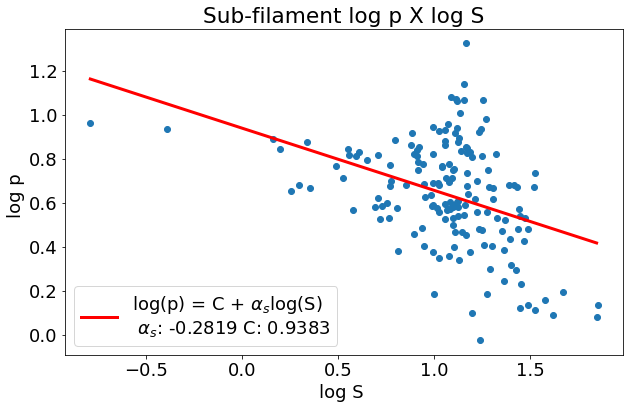

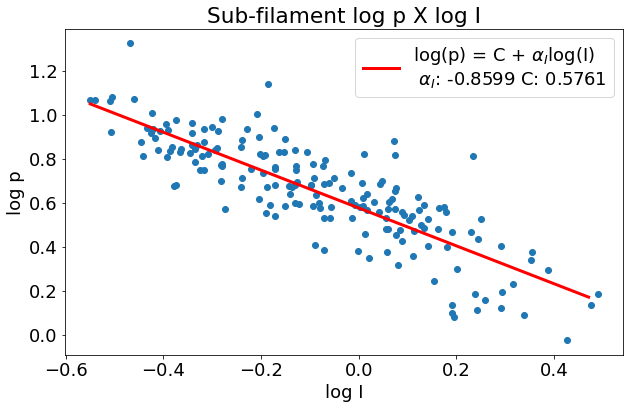

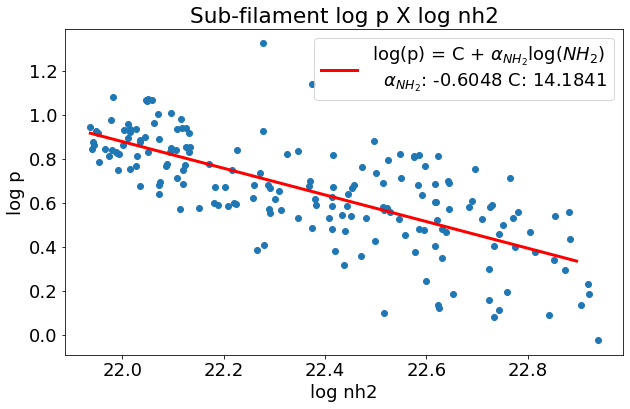

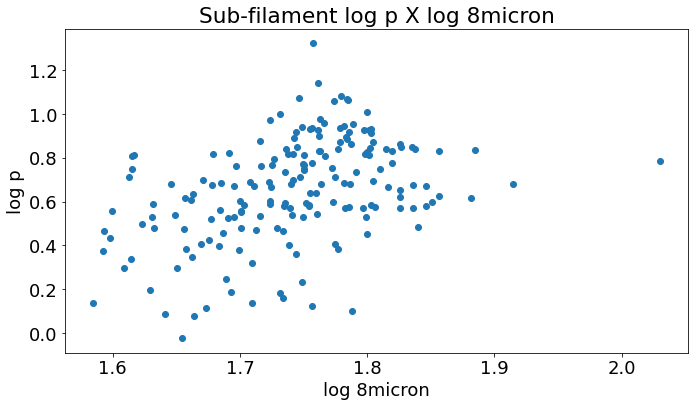

C : 0.7402269150704556
s index : -0.1507445766767012
I index : -0.8071919194897378
C : 13.122188049794575
s index : -0.11503869844478393
nh2 index : -0.551966231420116


In [44]:
def lin_fit(x, a, b):
    return a + b*x

s_fil_right_array = s_fil_right.data.flatten()
p_fil_right_array = p_fil_right.data.flatten()
I_fil_right_array = I_fil_right.data.flatten()
nh2_fil_right_array = nh2_fil_right.data.flatten()
micron8_fil_right_array = micron8_fil_right.data.flatten()



s_fil_right_array_ind = s_fil_right_array.copy()
s_fil_right_array_ind = s_fil_right_array_ind[::4]
p_fil_right_array_ind = p_fil_right_array.copy()
p_fil_right_array_ind = p_fil_right_array_ind[::4]
I_fil_right_array_ind = I_fil_right_array.copy()
I_fil_right_array_ind = I_fil_right_array_ind[::4]
nh2_fil_right_array_ind = nh2_fil_right_array.copy()
nh2_fil_right_array_ind = nh2_fil_right_array_ind[::4]
micron8_fil_right_array_ind = micron8_fil_right_array.copy()
micron8_fil_right_array_ind = micron8_fil_right_array_ind[::4]

log_s = np.log10(s_fil_right_array_ind)
log_p = np.log10(p_fil_right_array_ind)
log_I = np.log10(I_fil_right_array_ind)
log_nh2 = np.log10(nh2_fil_right_array_ind)
log_8micron = np.log10(micron8_fil_right_array_ind)


p_min = np.nanmin(log_p)
p_max = np.log(50)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.arange(p_min, p_max, 0.06)
s_bins = np.arange(s_min, s_max, 0.06)
I_bins = np.arange(I_min, I_max, 0.06)
nh2_bins = np.arange(nh2_min,nh2_max, 0.06)
micron8_bins = np.arange(micron8_min,micron8_max,0.06)


df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2})
df_log = df_log.dropna()

print(df_log.head)

PS_fil_right_param, PS_fil_right_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_fil_right = lin_fit(s_bins,PS_fil_right_param[0],PS_fil_right_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_fil_right_param, PI_fil_right_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_fil_right = lin_fit(I_bins,PI_fil_right_param[0],PI_fil_right_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_fil_right_param, Pnh2_fil_right_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_fil_right = lin_fit(nh2_bins,Pnh2_fil_right_param[0],Pnh2_fil_right_param[1])


# fig = plt.subplots(figsize =(15, 30))
# ax1 = plt.subplot(312)
# ax1.scatter(log_s,log_p)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_fil_right_param[1],C = PS_fil_right_param[0],linebreak='\n')
# ax1.plot(s_bins,PS_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax2 = plt.subplot(311)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_fil_right_param[1],C = PI_fil_right_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax3 = plt.subplot(313)
# ax3.scatter(log_nh2,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_fil_right_param[1],C = Pnh2_fil_right_param[0],linebreak='\n')
# ax3.plot(nh2_bins,Pnh2_FitFunc_fil_right,'r',linewidth=3,label = label_temp)

# ax1.set_title("Sub-filament log p X log S")
# ax1.set_ylabel('log p ')
# ax1.set_xlabel('log S ')
# ax2.set_title("Sub-filament log p X log I")
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')
# ax3.set_title("Sub-filament log p X log nh2")
# ax3.set_ylabel('log p')
# ax3.set_xlabel('log nh2')
# # ax1.set_xscale('linear')
# # ax1.set_yscale('linear')
# # ax2.set_xscale('linear')
# # ax2.set_yscale('linear')
# # ax3.set_xscale('linear')
# # ax3.set_yscale('linear')
# plt.tight_layout()
# ax1.legend()
# ax2.legend()
# ax3.legend()
# plt.show()

fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(log_s,log_p)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_fil_right_param[1],C = PS_fil_right_param[0],linebreak='\n')
ax1.plot(s_bins,PS_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax1.set_title("Sub-filament log p X log S")
ax1.set_ylabel('log p ')
ax1.set_xlabel('log S ')


fig = plt.subplots(figsize =(10, 6))
ax2 = plt.subplot(111)
ax2.scatter(log_I,log_p)
label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_fil_right_param[1],C = PI_fil_right_param[0],linebreak='\n')
ax2.plot(I_bins,PI_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax2.set_title("Sub-filament log p X log I")
ax2.set_ylabel('log p')
ax2.set_xlabel('log I')

fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(log_nh2,log_p)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_fil_right_param[1],C = Pnh2_fil_right_param[0],linebreak='\n')
ax3.plot(nh2_bins,Pnh2_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax3.set_title("Sub-filament log p X log nh2")
ax3.set_ylabel('log p')
ax3.set_xlabel('log nh2')

fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(log_8micron,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_outflow_param[1],C = Pnh2_outflow_param[0],linebreak='\n')
# ax4.plot(nh2_bins,Pnh2_FitFunc_outflow,'r',linewidth=3,label = label_temp)
ax4.set_title("Sub-filament log p X log 8micron")
ax4.set_ylabel('log p')
ax4.set_xlabel('log 8micron')



# ax1.set_xscale('linear')
# ax1.set_yscale('linear')
# ax2.set_xscale('linear')
# ax2.set_yscale('linear')
# ax3.set_xscale('linear')
# ax3.set_yscale('linear')
plt.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()



def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

p0 = -0.2278,-0.3994,2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('nh2 index :',PSI_param_lower[2])

Bootstrap error estimation of the sub-filament region.

In [41]:
s_fil_right_array = s_fil_right.data.flatten()
p_fil_right_array = p_fil_right.data.flatten()
nh2_fil_right_array = nh2_fil_right.data.flatten()

log_s = np.log(s_fil_right_array)
log_p = np.log(p_fil_right_array)
log_nh2 = np.log(nh2_fil_right_array)

# log_s = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# log_p = 10*np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# log_nh2 = 100*np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])


df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return np.sqrt(np.diag(param_cov))


bootarr = np.array(df_log)


bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))

# param, param_cov = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']),df_log['logp'])
# param_cov = curve_fitting(bootarr)

error in alpha_s 0.000934095725442513
error in alpha_nh2 0.00126589346385653


Analysis of the ridge region.

<bound method NDFrame.head of           logp      logs      logI     lognh2
93    1.445349  0.841383  1.214825  22.554479
120   1.449825  1.039353  0.866950  22.477231
121   0.901758  1.149371  1.851172  23.138442
122   0.331391  1.417395  1.948238  23.485061
147   1.047425  0.933945  0.873425  22.389988
...        ...       ...       ...        ...
1413  0.854814  1.252767 -0.114975  22.785978
1414  0.160676  1.588515  0.500447  23.126011
1441  0.538455  1.114795  0.286746  23.027951
1468  0.839355  1.124119 -0.272573  22.586606
1469  0.406426  1.524168  0.349538  23.002367

[169 rows x 4 columns]>


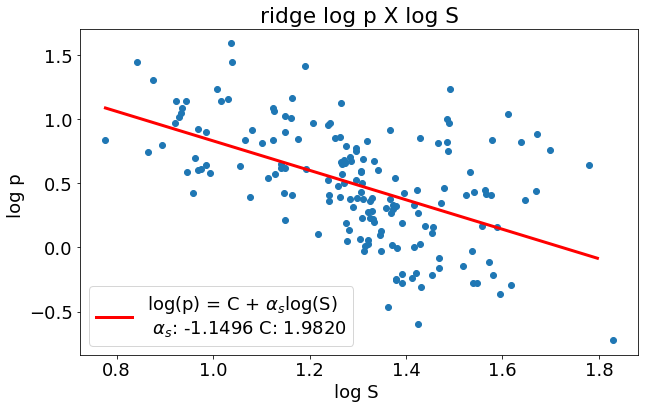

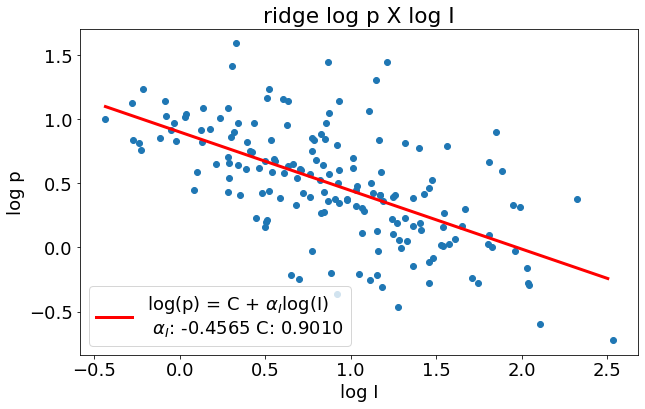

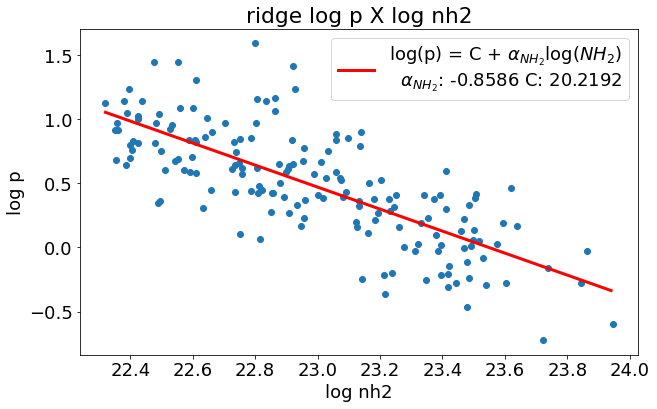

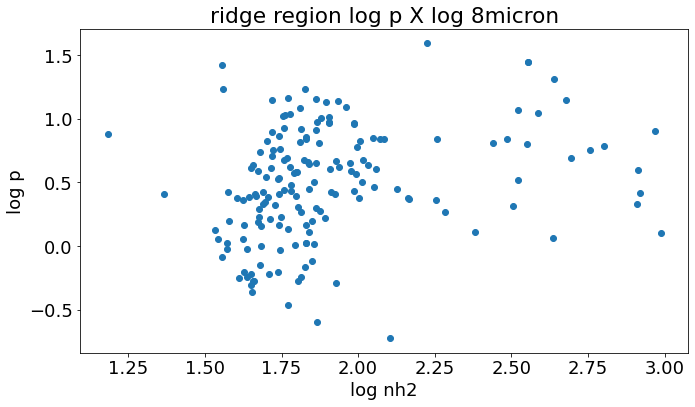

C : 1.9739947363195585
s index : -0.8788834627700507
I index : -0.3820889708534119
C : 18.119077307727395
s index : -0.4995643203915946
nh2 index : -0.739004699990056


In [45]:
def lin_fit(x, a, b):
    return a + b*x

s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
I_ridge_array = I_ridge.data.flatten()
nh2_ridge_array = nh2_ridge.data.flatten()
micron8_ridge_array = micron8_ridge.data.flatten()

s_ridge_array_ind = s_ridge_array.copy()
s_ridge_array_ind = s_ridge_array_ind[::4]
p_ridge_array_ind = p_ridge_array.copy()
p_ridge_array_ind = p_ridge_array_ind[::4]
I_ridge_array_ind = I_ridge_array.copy()
I_ridge_array_ind = I_ridge_array_ind[::4]
nh2_ridge_array_ind = nh2_ridge_array.copy()
nh2_ridge_array_ind = nh2_ridge_array_ind[::4]
micron8_ridge_array_ind = micron8_ridge_array.copy()
micron8_ridge_array_ind = micron8_ridge_array_ind[::4]

log_s = np.log10(s_ridge_array_ind)
log_p = np.log10(p_ridge_array_ind)
log_I = np.log10(I_ridge_array_ind)
log_nh2 = np.log10(nh2_ridge_array_ind)
log_8micron = np.log10(micron8_ridge_array_ind)

p_min = np.nanmin(log_p)
p_max = np.log(50)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
  

p_bins = np.arange(p_min, p_max, 0.06)
s_bins = np.arange(s_min, s_max, 0.06)
I_bins = np.arange(I_min, I_max, 0.06)
nh2_bins = np.arange(nh2_min,nh2_max, 0.06)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2})
df_log = df_log.dropna()

print(df_log.head)
PS_ridge_param, PS_ridge_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_ridge = lin_fit(s_bins,PS_ridge_param[0],PS_ridge_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_ridge_param, PI_ridge_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_ridge = lin_fit(I_bins,PI_ridge_param[0],PI_ridge_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_ridge_param, Pnh2_ridge_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_ridge = lin_fit(nh2_bins,Pnh2_ridge_param[0],Pnh2_ridge_param[1])


# fig = plt.subplots(figsize =(15, 30))
# ax1 = plt.subplot(312)
# ax1.scatter(log_s,log_p)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_ridge_param[1],C = PS_ridge_param[0],linebreak='\n')
# ax1.plot(s_bins,PS_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# ax2 = plt.subplot(311)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_ridge_param[1],C = PI_ridge_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# ax3 = plt.subplot(313)
# ax3.scatter(log_nh2,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_ridge_param[1],C = Pnh2_ridge_param[0],linebreak='\n')
# ax3.plot(nh2_bins,Pnh2_FitFunc_ridge,'r',linewidth=3,label = label_temp)

# ax1.set_title("ridge log p X log S")
# ax1.set_ylabel('log p ')
# ax1.set_xlabel('log S ')
# ax2.set_title("ridge log p X log I")
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')
# ax3.set_title("ridge log p X log nh2")
# ax3.set_ylabel('log p')
# ax3.set_xlabel('log nh2')
# # ax1.set_xscale('linear')
# # ax1.set_yscale('linear')
# # ax2.set_xscale('linear')
# # ax2.set_yscale('linear')
# # ax3.set_xscale('linear')
# # ax3.set_yscale('linear')
# plt.tight_layout()
# ax1.legend()
# ax2.legend()
# ax3.legend()
# plt.show()

fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(log_s,log_p)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_ridge_param[1],C = PS_ridge_param[0],linebreak='\n')
ax1.plot(s_bins,PS_FitFunc_ridge,'r',linewidth=3,label = label_temp)

fig = plt.subplots(figsize =(10, 6))
ax2 = plt.subplot(111)
ax2.scatter(log_I,log_p)
label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_ridge_param[1],C = PI_ridge_param[0],linebreak='\n')
ax2.plot(I_bins,PI_FitFunc_ridge,'r',linewidth=3,label = label_temp)

fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(log_nh2,log_p)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_ridge_param[1],C = Pnh2_ridge_param[0],linebreak='\n')
ax3.plot(nh2_bins,Pnh2_FitFunc_ridge,'r',linewidth=3,label = label_temp)

fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(log_8micron,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_outflow_param[1],C = Pnh2_outflow_param[0],linebreak='\n')
# ax4.plot(nh2_bins,Pnh2_FitFunc_outflow,'r',linewidth=3,label = label_temp)
ax4.set_title("ridge region log p X log 8micron")
ax4.set_ylabel('log p')
ax4.set_xlabel('log nh2')

ax1.set_title("ridge log p X log S")
ax1.set_ylabel('log p ')
ax1.set_xlabel('log S ')
ax2.set_title("ridge log p X log I")
ax2.set_ylabel('log p')
ax2.set_xlabel('log I')
ax3.set_title("ridge log p X log nh2")
ax3.set_ylabel('log p')
ax3.set_xlabel('log nh2')
# ax1.set_xscale('linear')
# ax1.set_yscale('linear')
# ax2.set_xscale('linear')
# ax2.set_yscale('linear')
# ax3.set_xscale('linear')
# ax3.set_yscale('linear')
plt.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()


def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

p0 = -0.2278,-0.3994,2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('nh2 index :',PSI_param_lower[2])

Bootstrap error analysis of ridge region

In [43]:
s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
nh2_ridge_array = nh2_ridge.data.flatten()

log_s = np.log(s_ridge_array)
log_p = np.log(p_ridge_array)
log_nh2 = np.log(nh2_ridge_array)

# log_s = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# log_p = 10*np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# log_nh2 = 100*np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])


df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return np.sqrt(np.diag(param_cov))


bootarr = np.array(df_log)


bootresult = bootstrap(bootarr,10,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))

# param, param_cov = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']),df_log['logp'])
# param_cov = curve_fitting(bootarr)

error in alpha_s 0.0012164372343404074
error in alpha_nh2 0.0018040380688378525
